# Модель подавления поверхностных волн

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Критика](#Критика)

## Постановка задачи

Подавить шумы, связанные с поверхностными волнами, на полевых сейсмограммах.

## Датасет

Исходная сейсмограмма (176К трасс, 51 полевая запись) и сейсмограмма после первой итерации подавления шума.

Создание индекса полевых записей:

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import segyio

sys.path.append('..')

from batchflow import Dataset, DatasetIndex, Pipeline, B, V, best_practice
from batchflow.models.tf import UNet

from geolog import SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex

%env CUDA_VISIBLE_DEVICES=4

path_raw = '/notebooks/egor/noise_data/D01_Raw_shots.sgy'
path_lift = '../../noise_data/D02_LIFT_1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index._idf.head()

env: CUDA_VISIBLE_DEVICES=4


file_id TraceNumber offset  \
                                                      raw                      
FieldRecord                                                                    
111906       /notebooks/egor/noise_data/D01_Raw_shots.sgy        1656     35   
111906       /notebooks/egor/noise_data/D01_Raw_shots.sgy        1657     36   
111906       /notebooks/egor/noise_data/D01_Raw_shots.sgy        1655     78   
111906       /notebooks/egor/noise_data/D01_Raw_shots.sgy        1658     79   
111906       /notebooks/egor/noise_data/D01_Raw_shots.sgy        1654    127   

            TRACE_SEQUENCE_FILE                          file_id  \
                            raw                             lift   
FieldRecord                                                        
111906                        1  ../../noise_data/D02_LIFT_1.sgy   
111906                        2  ../../noise_data/D02_LIFT_1.sgy   
111906                        3  ../../noise_data/D02_LIFT_1.sgy   
111906                        4  ../../noise_data/D02_LIFT_1.sgy   
111906                        5  ../../noise_data/D02_LIFT_1.sgy   

            TRACE_SEQUENCE_FILE  
                           lift  
FieldRecord                      
111906                        1  
111906                        2  
111906                        3  
111906                        4  
111906                        5

Выделение индекса обучающей части (5 первых полевых записей)

In [2]:
train_index = index.create_subset(index.indices[:5])

Пример исходной сейсмограммы

In [3]:
batch = (Dataset(train_index, SeismicBatch).next_batch(5)
         .load(components=('raw', 'lift'), sort_by='offset'))

In [5]:
cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow(np.vstack(batch.raw).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

Результат ручной обработки поверхностных волн

In [6]:
cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow(np.vstack(batch.lift).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Архитектура

Используется модель типа U-net глубиной 4. Задание конфигурации модели:

In [7]:
import tensorflow as tf
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3001, 1)}, 
                   y={'name':'targets', 'shape': (3001, 1)}),
    'body/filters': [8, 16, 32, 64, 128],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

## Обучение

Пайплайн обучения модели

In [8]:
train_set = Dataset(TraceIndex(train_index).shuffle(), SeismicBatch)

In [9]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(list(batch.raw), -1),
                          'y': np.expand_dims(list(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Запуск обучения

In [10]:
batch_size = 64

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/810 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|█████████▉| 809/810 [01:13<00:00, 10.98it/s]


График функции потерь в зависимости от числа итераций

In [11]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Сохранение модели

In [10]:
train_pipeline.save_model('unet', './wide_model')

## Инференс

Пайплайн инференса

In [11]:
model_config = {
    "build": False,
    "load": {"path": './wide_model'},
}

In [12]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(list(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .load(components='raw')
                    .import_model('unet', train_pipeline)
#                     .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('predictions', init_on_each_run=list())
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('predictions'), mode="a")
                   )

Запуск процедуры инференса

In [13]:
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

In [14]:
batch_size = 1000
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:01<00:00,  2.64it/s]


Сборка трасс

In [15]:
predicts = np.vstack(predict_pipeline.get_variable("predictions"))[:, :, 0]

Результат подавлениия поверхностных волн

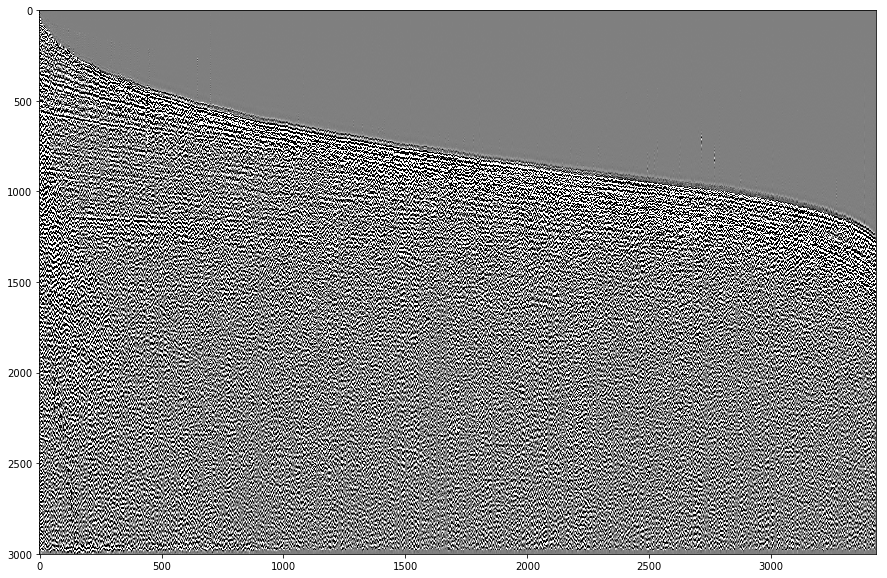

In [16]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(predicts.T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Оценка модели

Разница между исходной сейсмограммой и предсказанием модели

In [17]:
batch = (Dataset(index.create_subset(index.indices[20:21]), SeismicBatch).next_batch(1)
         .load(components=('raw', 'lift'), sort_by='TRACE_SEQUENCE_FILE'))

raw = np.vstack(batch.raw)
lift = np.vstack(batch.lift)

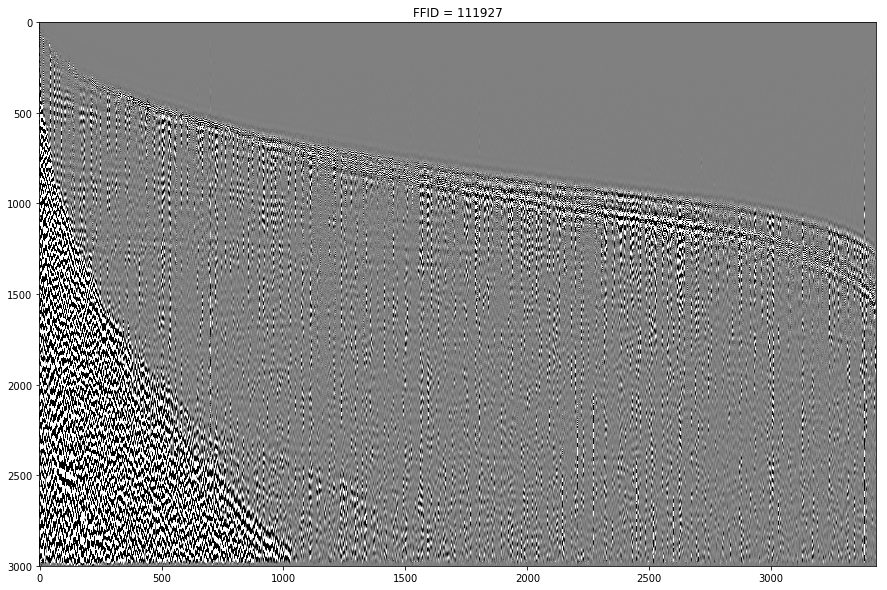

In [18]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow((raw - predicts).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

Разница между обработкой LIFT и ML

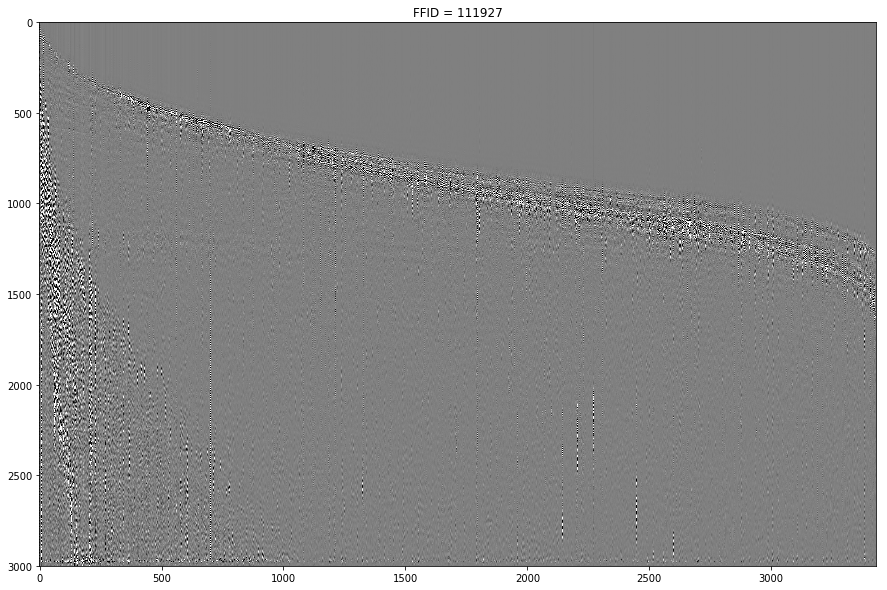

In [19]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow((lift - predicts).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

Сравнение спектров в области поверхностных волн для ручной и обработки LIFT и ML

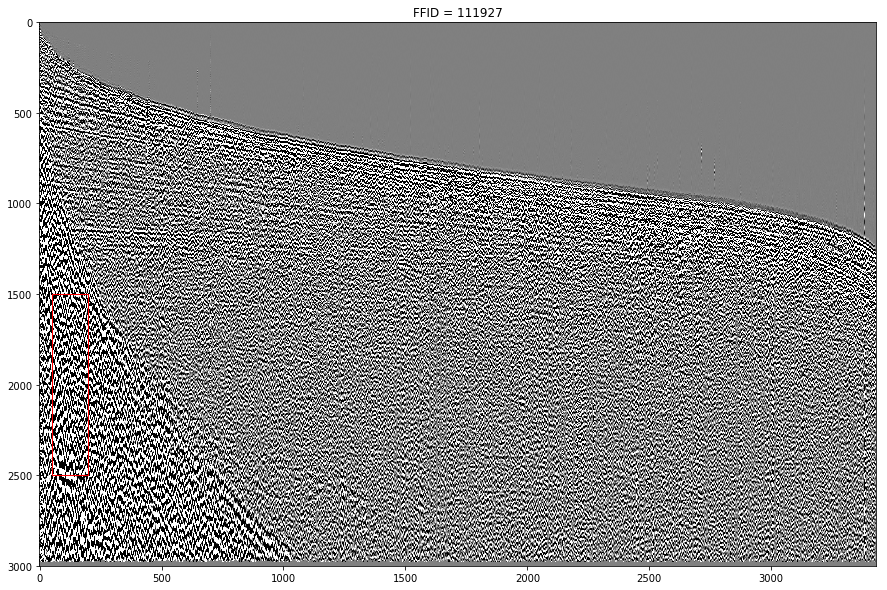

In [20]:
dw = (slice(50, 200), slice(1500, 2500))

cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow((raw).T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

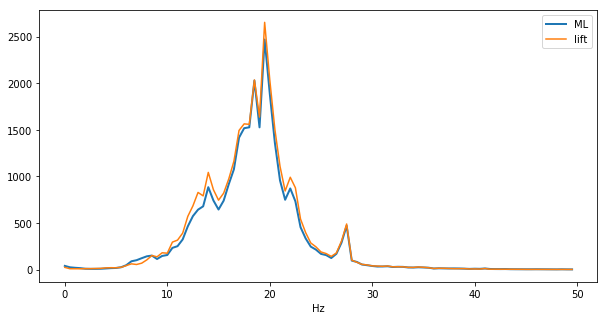

In [21]:
spec_ml = abs(np.fft.rfft(predicts[dw], axis=1))**2
spec_lift = abs(np.fft.rfft(lift[dw], axis=1))**2
freqs = np.fft.rfftfreq(len(predicts[dw][0]), d=0.002)

ds = freqs < 50
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

Сравнение спектров в области без поверхностных волн для обработки LIFT и ML

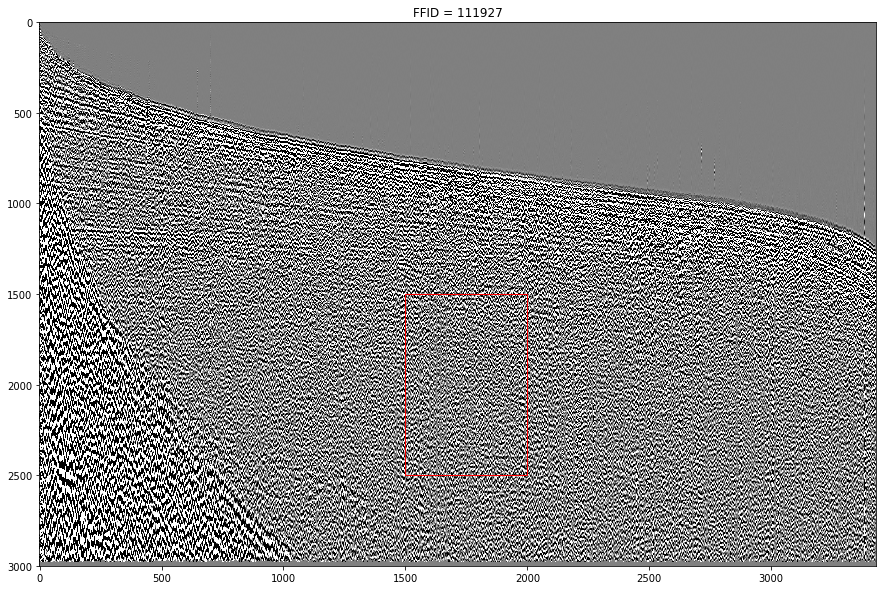

In [22]:
dw =(slice(1500, 2000), slice(1500, 2500))

cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow((raw).T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

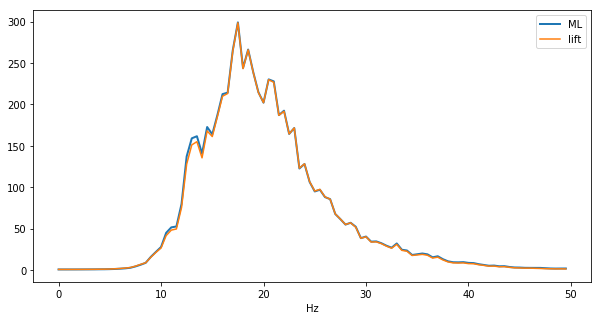

In [23]:
spec_ml = abs(np.fft.rfft(predicts[dw], axis=1))**2
spec_lift = abs(np.fft.rfft(lift[dw], axis=1))**2
freqs = np.fft.rfftfreq(len(predicts[dw][0]), d=0.002)

ds = freqs < 50
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

## Критика

Спектры сигналов ручной и ML обработки хорошо совпадают. В то же время, на разнице LIFT - ML обработка встречаются "аномальные" трассы  

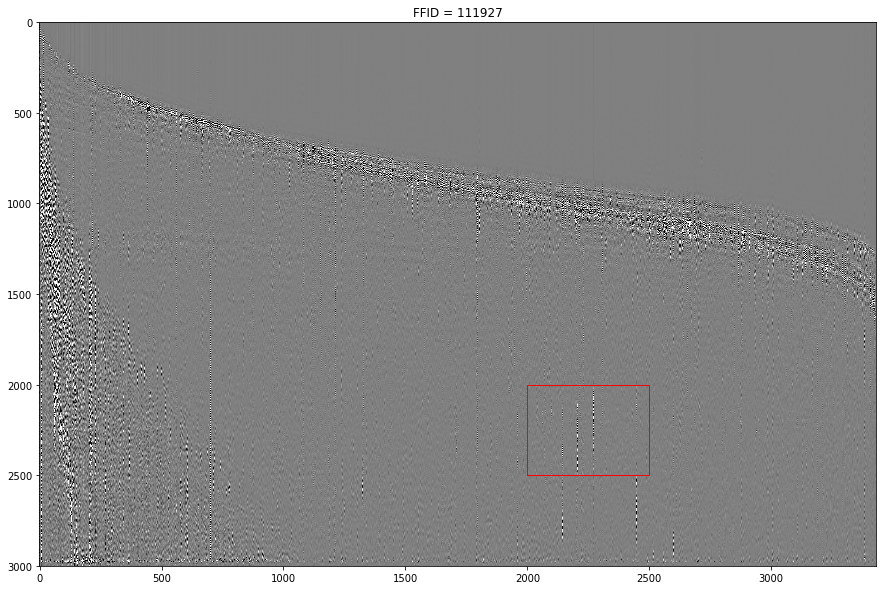

In [24]:
dw = (slice(2000, 2500), slice(2000, 2500))

cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow((lift - predicts).T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

Сравнение спектров RAW - LIFT и RAW - ML

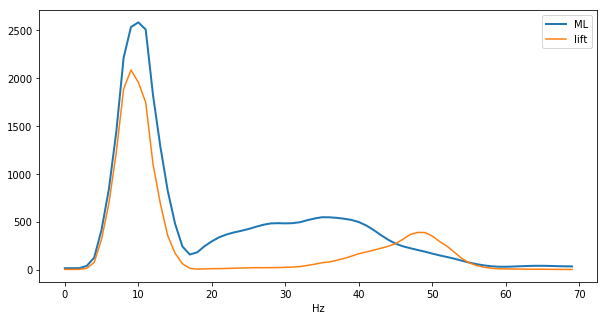

In [25]:
spec_ml = abs(np.fft.rfft((raw - predicts)[dw], axis=1))**2
spec_lift = abs(np.fft.rfft((raw - lift)[dw], axis=1))**2
freqs = np.fft.rfftfreq(len(predicts[dw][0]), d=0.002)

ds = freqs < 70
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

Усреднение с помощью медианы показывает, что различие может быть обусловлено "аномальными" трассами

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.median(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.median(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

Увеличенный фрагмент из рамки

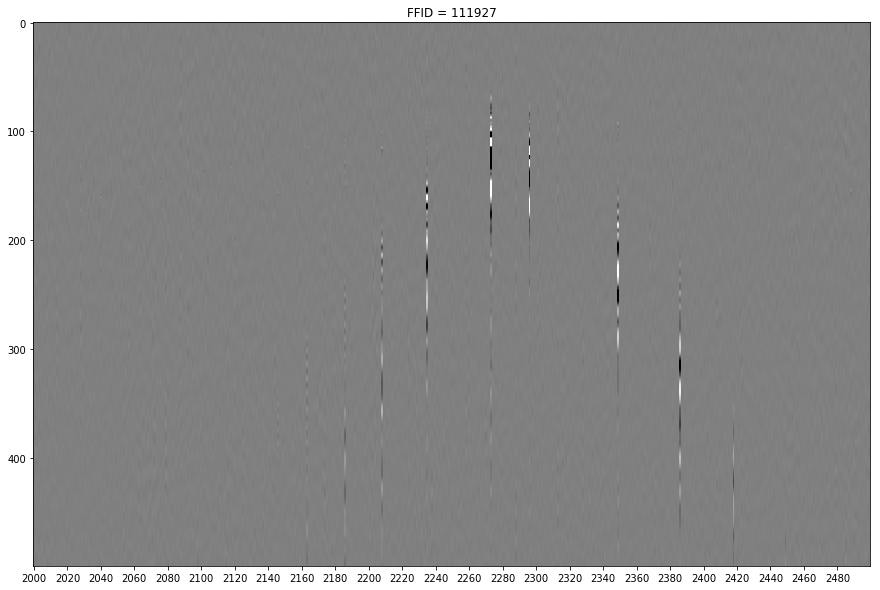

In [27]:
cv = 10.1
plt.figure(figsize=(15, 10))
plt.imshow((raw)[dw].T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.xticks(np.arange(0, dw[0].stop - dw[0].start, 20),
           np.arange(dw[0].start, dw[0].stop, 20))
plt.show()

Исходный сигнал на трассах с 2200 по 2220 в области рамки, виден пример "аномального" сигнала

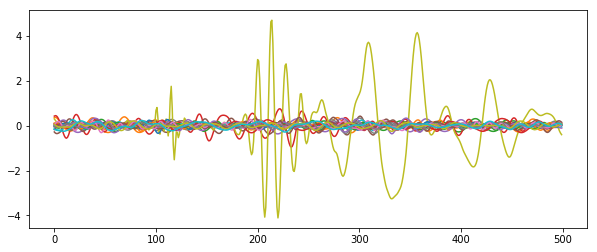

In [28]:
plt.figure(figsize=(10, 4))
plt.plot((raw)[2200:2220, 2000:2500].T)
plt.show()

Разница RAW - ML

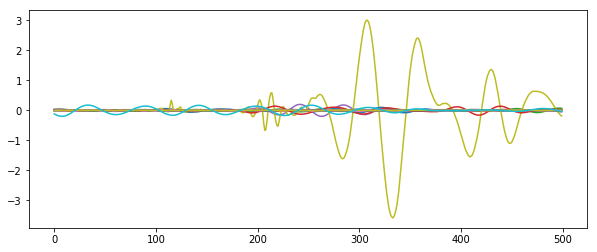

In [29]:
plt.figure(figsize=(10, 4))
plt.plot((raw - predicts)[2200:2220, 2000:2500].T)
plt.show()

Разница RAW - LIFT

In [30]:
plt.figure(figsize=(10, 4))
plt.plot((raw - lift)[2200:2220, 2000:2500].T)
plt.show()

Разница LIFT - ML

In [31]:
plt.figure(figsize=(10, 4))
plt.plot((lift - predicts)[2200:2220, 2000:2500].T)
plt.show()

Найдем норму разности ML - LIFT по каждой трассе

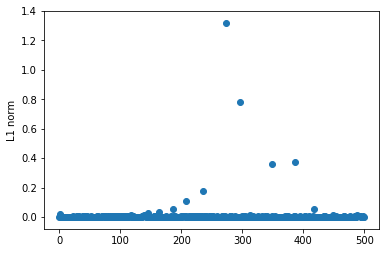

In [32]:
errs = np.mean(abs((lift - predicts)[dw]), axis=1)
plt.scatter(np.arange(len(errs)), errs)
plt.ylabel('L1 norm')
plt.show()

Выбросим из рамки трассы, для которых ошибка > 0.03

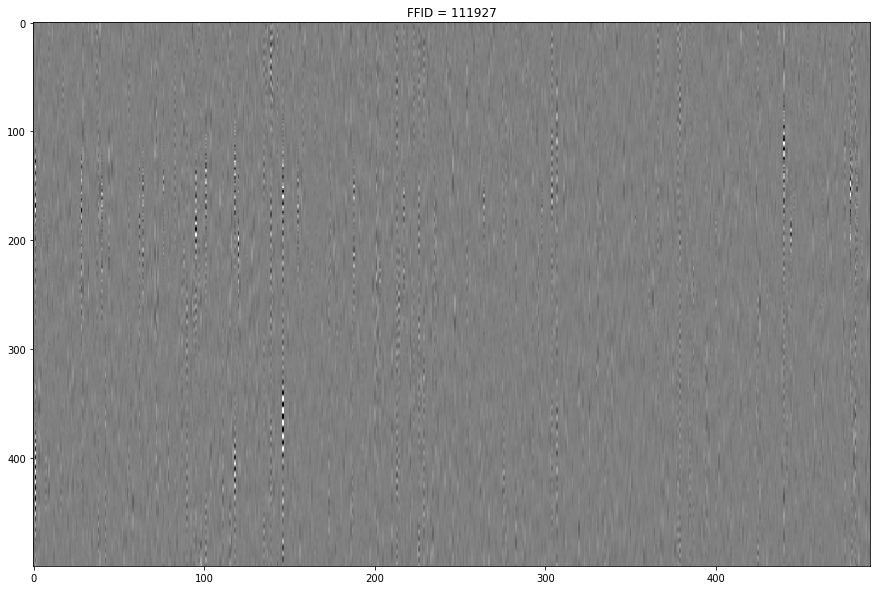

In [33]:
cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow((lift - predicts)[dw][errs < 0.03].T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

Теперь сравним спектры оставшихся трасс и увидим, что стало хорошо

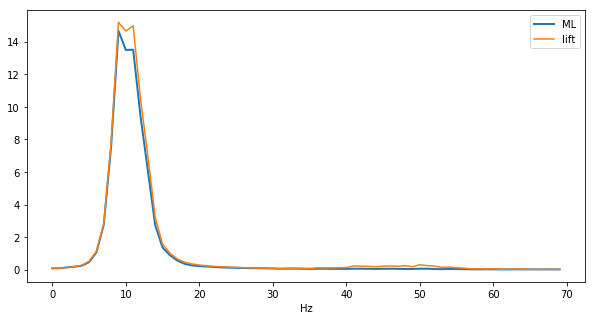

In [34]:
spec_ml = abs(np.fft.rfft((raw - predicts)[dw][errs < 0.03], axis=1))**2
spec_lift = abs(np.fft.rfft((raw - lift)[dw][errs < 0.03], axis=1))**2
freqs = np.fft.rfftfreq(len(predicts[dw][0]), d=0.002)

ds = freqs < 70
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

Область без "аномальных" трасс

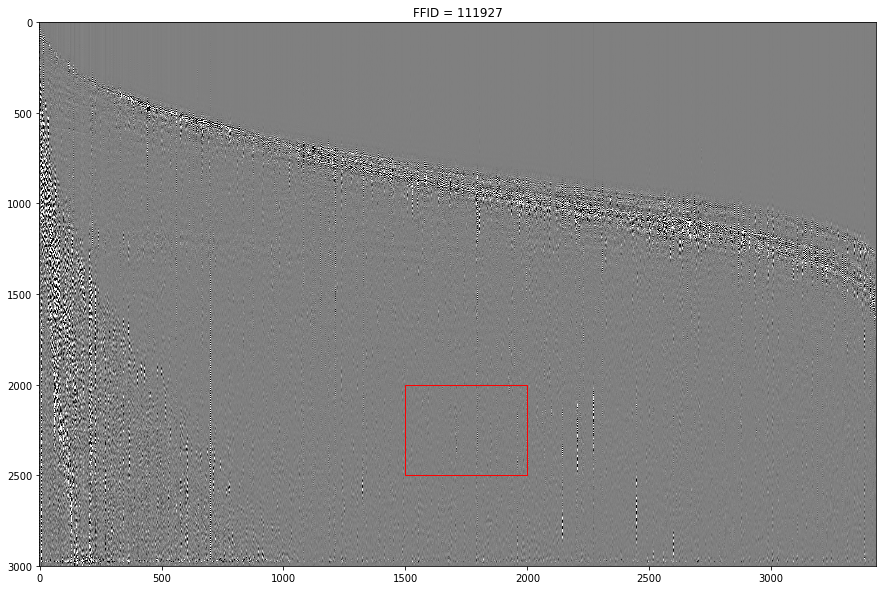

In [35]:
dw = (slice(1500, 2000), slice(2000, 2500))

cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow((lift - predicts).T, vmin=-cv, vmax=cv, cmap='gray')
rect = patches.Rectangle((dw[0].start, dw[1].start),
                         dw[0].stop - dw[0].start, dw[1].stop - dw[1].start,
                         linewidth=1, edgecolor='r', facecolor='none')
plt.axes().add_patch(rect)
plt.axes().set_aspect('auto')
plt.title("FFID = {}".format(batch.indices[0]))
plt.show()

Обычное усреднение

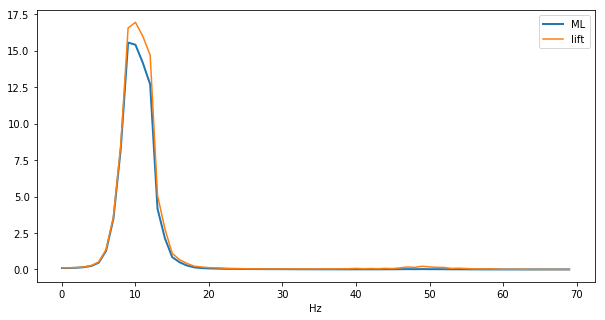

In [36]:
spec_ml = abs(np.fft.rfft((raw - predicts)[dw], axis=1))**2
spec_lift = abs(np.fft.rfft((raw - lift)[dw], axis=1))**2
freqs = np.fft.rfftfreq(len(predicts[dw][0]), d=0.002)

ds = freqs < 70
plt.figure(figsize=(10, 5))
plt.plot(freqs[ds], np.mean(spec_ml, axis=0)[ds], label='ML', lw=2)
plt.plot(freqs[ds], np.mean(spec_lift, axis=0)[ds], label='lift')
plt.xlabel('Hz')
plt.legend()
plt.show()

Необходимо научиться обрабатывать "аномальные" трассы.